## Redes Neuronales Informadas por Física
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Trabajo Práctico Nº1

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Ezequiel Maudet       | eze.maudet@gmail.com      | a1812   |
| Federico Zoya         | fzoya33@gmail.com         | a1828   |

### Flow in a Square Cavity (Lid-Driven Cavity)

#### Description:

This is a standard test case to verify the accuracy of numerical methods solving the incompressible Navier-Stokes equations. The domain is $\Omega = [0,1] \times [0,1]$

Governing equations in steady state:

- Momentum equation (vector form): $(\mathbf{u} \cdot \nabla) \mathbf{u} = - \nabla p + \frac{1}{Re} \nabla^2 \mathbf{u}$ in $\Omega$

- Continuity equation (incompressibility): $\nabla \cdot \mathbf{u} = 0$ in $\Omega$

Boundary conditions:  

- No-slip condition on the side and bottom walls (velocity zero).
- Top wall moves at a constant velocity in the ( +x ) direction.

### 1. LIBRARIES AND GENERAL PARAMETERS

In [50]:
import scipy.io                     # for matlab files manipulation
import os                           # for files manipulation
import pandas as pd                 # for data manipulation
import numpy as np                  # for data manipulation
import matplotlib.pyplot as plt     # for plotting


import torch                        # For neural networks models
# from tqdm import tqdm               # For progress bar

In [51]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [53]:
import random

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

set_seed(42)

#### 2. PROBLEM DEFINITION

In [54]:
# Domain definition
x_min = 0
x_max = 1

y_min = 0
y_max = 1

In [55]:
# Velocity boundary conditions

U_bc = [0, 0, 0, 1]     # [left, right, bot, top]
V_bc = [0, 0, 0, 0]     # [left, right, bot, top]


### 3. GROUND TRUTH SOLUTION

We load the reference solution obtained by finite element analysis.

In [56]:
folder = 'Re-100'

# Read all files in folder
files = os.listdir(folder)

# Filter only MatLab files
mat_files = [f for f in files if f.endswith('.mat')]

print(mat_files)

['pressure.mat', 'velocity.mat']


In [57]:
def mat2df(mat_file):
    """
    Load a .mat file and convert its variables into a pandas DataFrame.
    
    Parameters:
    - mat_file: str, path to the .mat file
    
    Returns:
    - df: pandas.DataFrame with variables as columns
    """
    file_path = os.path.join(folder, mat_file)
    data = scipy.io.loadmat(file_path)
    variables = {}
    for key in data:
        if not key.startswith('__'):
            value = data[key]
            # Convert scalar values to list
            if np.isscalar(value):
                variables[key] = [value]
            elif isinstance(value, np.ndarray):
                # Flatten array if necessary
                if value.ndim == 1:
                    variables[key] = value
                else:
                    variables[key] = value.flatten()
    # Create DataFrame
    df = pd.DataFrame(variables)
    return df

In [58]:
df_pressure = mat2df(mat_files[0])
df_pressure.head(5)

,x,y,z,p
0,0.00,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.000013
3,0.03,0.0,0.0,-0.000038
4,0.04,0.0,0.0,-0.000131


In [59]:
df_velocity = mat2df(mat_files[1])
df_velocity.head(5)

,x,y,z,u,v,w
0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.01,0.0,0.0,0.0,0.0,0.0
2,0.02,0.0,0.0,0.0,0.0,0.0
3,0.03,0.0,0.0,0.0,0.0,0.0
4,0.04,0.0,0.0,0.0,0.0,0.0


In [60]:
df_fem = pd.merge(df_velocity[['x', 'y', 'u', 'v']], df_pressure[['x', 'y', 'p']],  on=['x', 'y'], how='inner')
df_fem.head(5)

,x,y,u,v,p
0,0.00,0.0,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.0,0.000013
3,0.03,0.0,0.0,0.0,-0.000038
4,0.04,0.0,0.0,0.0,-0.000131


In [61]:
ndata = df_fem.shape[0]
ndata

20201

Contour plot for the FEM results:

In [62]:
from scipy.interpolate import griddata

def contourplot_df(df, coord_cols, value_col, levels=50):
    # Extract node coordinates and nodal values
    points = df[['x', 'y']].values
    values = df[value_col].values

    # Create grid for plotting
    grid_x, grid_y = np.mgrid[
        points[:,0].min():points[:,0].max():100j,
        points[:,1].min():points[:,1].max():100j
    ]

    # Interpolate nodal values onto grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Plot the contour
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='turbo')
    plt.colorbar(contour)
    plt.title(f'FEM results contour plot of {value_col}')
    plt.xlabel(coord_cols[0])
    plt.ylabel(coord_cols[1])
    plt.axis('equal')
    # plt.show()

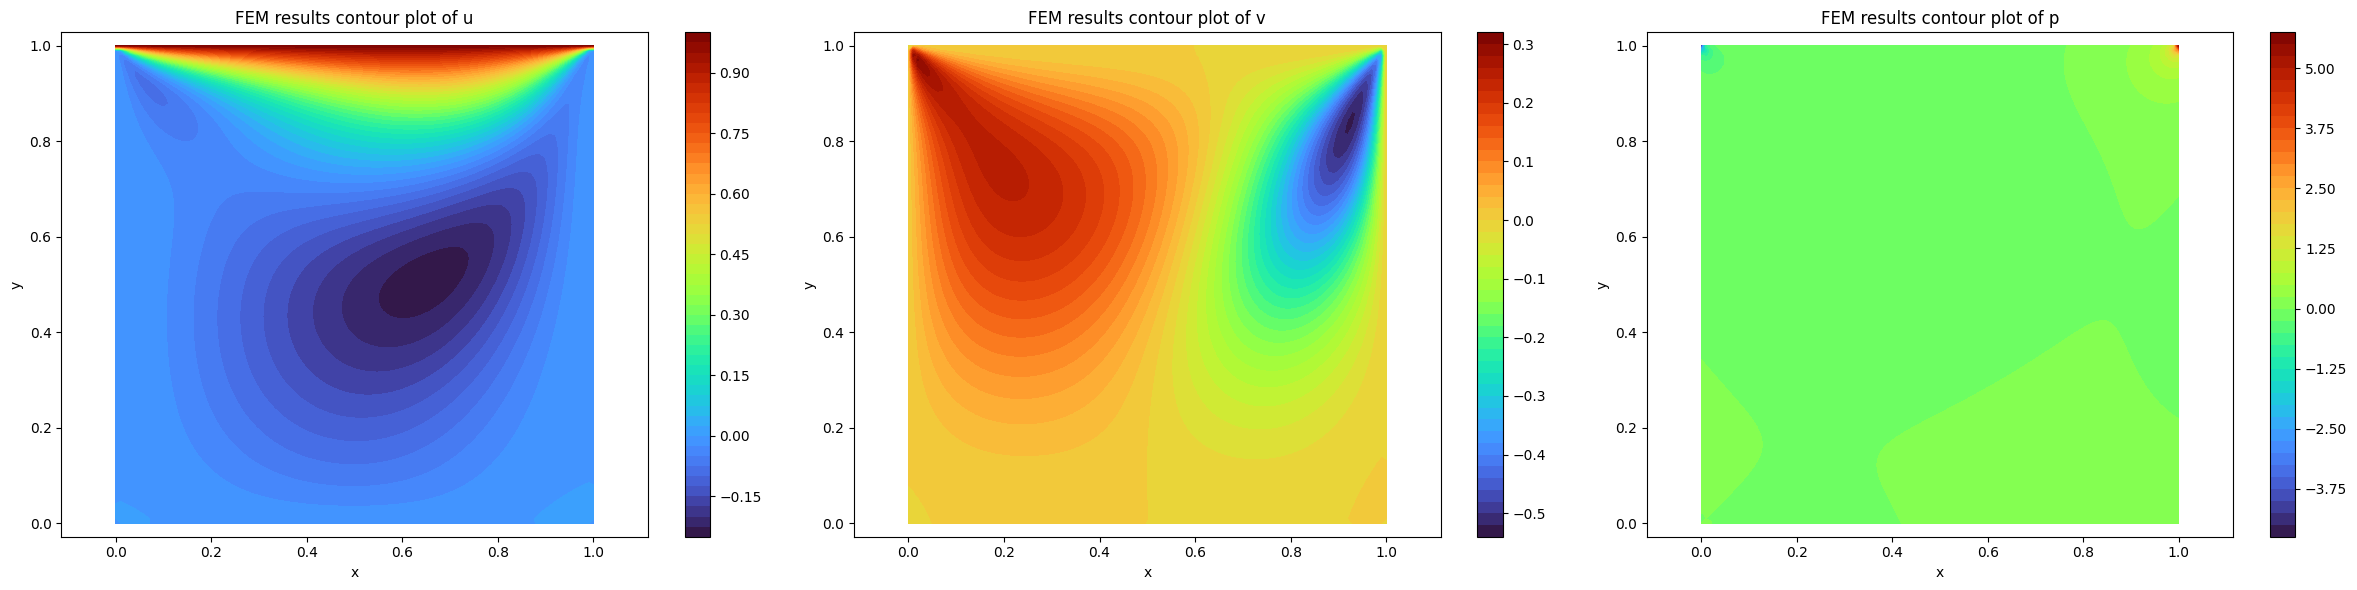

In [63]:
variables = ['u', 'v', 'p']
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, var in enumerate(variables):
    plt.sca(axes[i])
    contourplot_df(df_fem, ['x', 'y'], var)
    
for i, var in enumerate(variables):
    axes[i].set_title(f'FEM results contour plot of {var}')

plt.tight_layout()
plt.show()

### 4. DATA GENERATION

In [64]:
tags = ["Domain", "BoundaryConditions"]
isData = True           # Flag to indicate whether the analysis would use labelled data or not
nsamples = 10           # Number of labelled data to be used in the analysis

# Initialize list of dataset objects
ds_uniform = []
ds_random = []

#### 4.1 Collocation points

We generate two sets of collocation points: one inside the domain where the PDE residual will be evaluated, and the other along the boundaries where conditions will be enforced.

We define an auxiliary function capable to generate both uniform and randomly distribuited collocation points.

In [65]:
def get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_eq, random = True):
    """
    Generate collocation points for domain and boundary conditions.

    Args:
    - x_min, x_max: Minimum and maximum values for x-axis.
    - y_min, y_max: Minimum and maximum values for y-axis.
    - n_pde: Number of points for PDE domain.
    - n_bc: Number of points for each boundary.
    - random: Flag to choose between random and uniform distribution.
    - device: Device on which tensors should be allocated.

    Returns:
    - X_dom_tensor: Tensor containing the domain points.
    - X_bc_tensor: Tensor containing the boundary points.
    """
    if random:
        
        delta_x = x_max - x_min
        delta_y = y_max - y_min
        
        rand_aux = torch.rand((n_pde + 2 * n_bc, 2), device = device)
        
        x_dom = (x_min + delta_x * rand_aux[:n_pde, 0]).to(torch.float32)
        y_dom = (y_min + delta_y * rand_aux[:n_pde, 1]).to(torch.float32)
        
        y_left = (y_min + delta_y * rand_aux[n_pde:(n_pde + n_bc), 1]).to(torch.float32)
        y_right = (y_min + delta_y * rand_aux[-n_bc:, 1]).to(torch.float32)
    
        x_bot = (x_min + delta_x * rand_aux[n_pde:(n_pde + n_bc), 0]).to(torch.float32)
        x_top = (x_min + delta_x * rand_aux[-n_bc:, 0]).to(torch.float32)

    else:
        # Adjust n_pde for uniform case
        n_pde_sqrt = int(np.sqrt(n_pde))
        n_pde = n_pde_sqrt**2
        
        # Crear una cuadrícula 2D de tamaño n_pde x n_pde
        x_vals = torch.linspace(x_min, x_max, n_pde_sqrt, device=device)
        y_vals = torch.linspace(y_min, y_max, n_pde_sqrt, device=device)
        X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing='ij')

        # Aplanar las mallas en vectores 1D si quieres usar en los datos
        x_dom = X_grid.reshape(-1)
        y_dom = Y_grid.reshape(-1)    
        
        y_left = torch.linspace(y_min, y_max, n_bc, device = device)
        y_right = y_left.clone()
        
        x_bot = torch.linspace(x_min, x_max, n_bc, device = device)
        x_top = x_bot.clone()

    x_left = x_min * torch.ones(n_bc)
    x_right = x_max * torch.ones(n_bc)
    
    y_bot = y_min * torch.ones(n_bc)
    y_top = y_max * torch.ones(n_bc)

    # Combine all domain points
    X_dom_tensor = torch.stack((x_dom, y_dom), dim=1)

    # Combine all boundary points
    X_bc_tensor = torch.cat([
                torch.stack((x_left, y_left), dim=1),
                torch.stack((x_right, y_right), dim=1),
                torch.stack((x_bot, y_bot), dim=1),
                torch.stack((x_top, y_top), dim=1),
            ], axis=0)

    Y_dom_tensor = torch.zeros((n_pde, n_eq), device=device)

    return X_dom_tensor, Y_dom_tensor, X_bc_tensor

In [66]:
from torch.utils.data import TensorDataset

# Number of collocation points
n_pde = 1_000       # for domain
n_bc = 100          # for Boundary conditions

X_dom_uniform_tensor, Y_dom_uniform_tensor, X_bc_uniform_tensor = get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc//4, n_eq = 3, random = False)
X_dom_rand_tensor, Y_dom_rand_tensor, X_bc_rand_tensor = get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc//4,  n_eq = 3, random = True)

In [67]:
X_dom_uniform_tensor

tensor([[0.0000, 0.0000],
        [0.0000, 0.0333],
        [0.0000, 0.0667],
        ...,
        [1.0000, 0.9333],
        [1.0000, 0.9667],
        [1.0000, 1.0000]])

#### 4.2 Boundary Conditions

In [68]:
u_tensors = [ui * torch.ones((n_bc // 4, 1)) for ui in U_bc]
v_tensors = [vi * torch.ones((n_bc // 4, 1)) for vi in V_bc]

u_bc_tensor = torch.cat(u_tensors, axis=0)
v_bc_tensor = torch.cat(v_tensors, axis=0)

Y_bc_tensor = torch.cat([u_bc_tensor, v_bc_tensor], dim=1)

#### 4.3 Datasets generation

In [69]:
ds_uniform.append(TensorDataset(X_dom_uniform_tensor, Y_dom_uniform_tensor))
ds_uniform.append(TensorDataset(X_bc_uniform_tensor, Y_bc_tensor))

ds_random.append(TensorDataset(X_dom_rand_tensor, Y_dom_rand_tensor))
ds_random.append(TensorDataset(X_bc_rand_tensor, Y_bc_tensor))

#### 4.4 Labelled data

In [70]:
if isData:
    tags.append("LabelledData")
    idx_data = np.random.choice(range(ndata), nsamples, replace=False)
    
    data_np = df_fem.iloc[idx_data].to_numpy()                      # Convert df to numpy
    data_tensor = torch.from_numpy(data_np).float().to(device)      # Convert numpy to torch tensor

    X_data = data_tensor[:, :2]     # columns (x, y)
    Y_data = data_tensor[:, 2:]     # columns (u, v, p)

    ds_uniform.append(TensorDataset(X_data, Y_data))
    ds_random.append(TensorDataset(X_data, Y_data))

**RESPUESTA PUNTO 3**

La inclusión de datos rotulados le permite al modelo combinar información de la física a través de las ecuaciones de gobierno con la información de datos "reales" resultando en un modelo más robusto. 

En términos prácticos, los puntos rotulados actúan como un refuerzo del aprendizaje supervisado, mientras que los puntos de colocación garantizan la consistencia de la solución física en todo el dominio.

El dataset de datos rotulados se complementa con el par de datasets del dominio y de la condición de borde.

#### 4.5 Plot grid

In [71]:
# Dictionary of dataset objects
datasets_uniform = dict(zip(tags, ds_uniform))
datasets_random = dict(zip(tags, ds_random))

In [72]:
def plot_grid(dataset, title = None):
    # Plot the locations of the collocation points in the space domain
    X_dom = (dataset["Domain"][:][0]).data.cpu().numpy()
    X_bc = (dataset["BoundaryConditions"][:][0]).data.cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_dom[:,0], X_dom[:, 1], s=4, c='r', label=f'N_dom={len(X_dom)}')
    ax.scatter(X_bc[:, 1:2], X_bc[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc)}')
    if isData:
        X_data = (dataset["LabelledData"][:][0]).data.cpu().numpy()
        ax.scatter(X_data[:, 0], X_data[:, 1], s=30, c='g', label=f'N_Data={len(X_data)}', marker='*')
    ax.legend()
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    if title is not None:
        plt.title(title)
    plt.show()

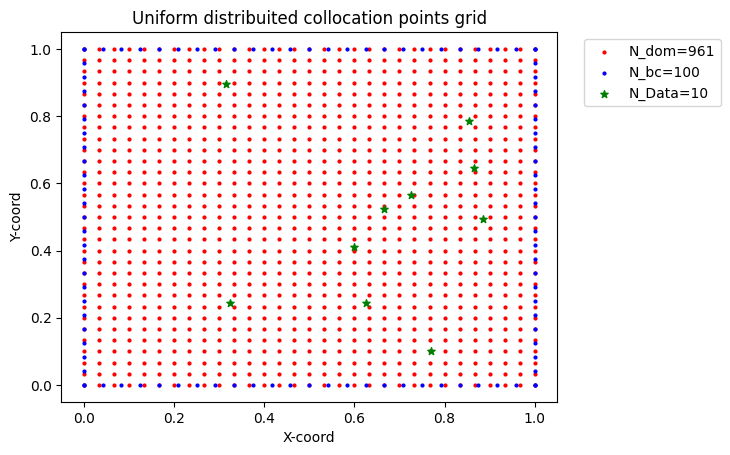

In [73]:
plot_grid(datasets_uniform, title='Uniform distribuited collocation points grid')

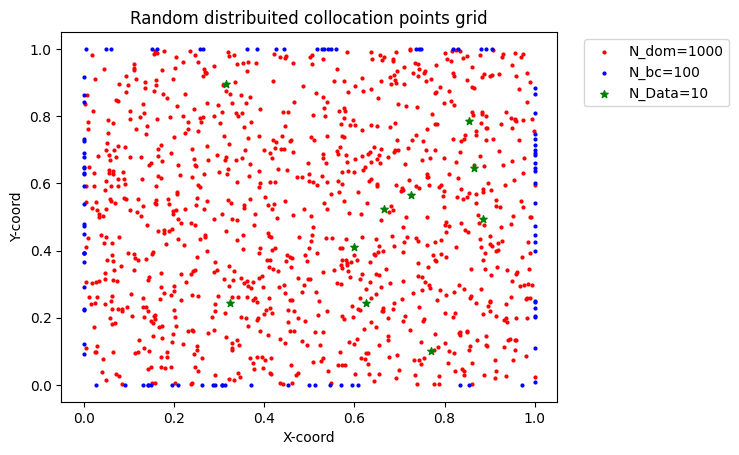

In [74]:
plot_grid(datasets_random, title='Random distribuited collocation points grid')

**RESPUESTA PUNTO 4**

Las fronteras físicas del dominio forman parte del dominio y, por ende, ahí también se tienen que cumplir las ecuaciones que gobiernan la física del problema, lo cual se hace mínimizando el residuo en los puntos de colocación. Por lo tanto, el sub-conjunto de puntos de colocación dentro del dominio donde la PDE va a ser resuelta debe incluir las fronteras físicas a los efectos de forzar las ecuaciones de gobierno del problema en esas regiones. En paralelo, se debe definir un sub-conjunto de puntos sobre las fronteras físicas en donde las  condiciones de borde están prescriptas. Adicionalmente, si el problema fuese *time-dependent¨*, se deberá definir otro sub-conjunto de puntos a lo largo de la coordenada temporal.

### 5. PINN IMPLEMENTATION

Implementamos la solución usando PyTorch.

#### 5.1 Model architecture

Definimos una FC NN que toma las coordenadas espaciales *(x,y)* como inputs y devuelve los campos velocidades *u*,*v* y presión como outputs.

- **INPUTS**:
    1. Position vector x-component *x*
    2. Position vector x-component *x*

- **OUTPUTS**:
    1. Velocity vector x-component *u*
    2. Velocity vector y-component *v*
    3. Pressure scalar *p*

In [75]:
import torch.nn as nn
import torchinfo as torchinfo

# Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters.Device
        self.Xmin = model_parameters.Xmin
        self.Xmax = model_parameters.Xmax
        self.Ymin = model_parameters.Ymin
        self.Ymax = model_parameters.Ymax
        self.Reynolds = model_parameters.Reynolds
        self.InputDimensions = model_parameters.InputDimensions
        self.OutputDimensions = model_parameters.OutputDimensions
        self.NumberOfNeurons = model_parameters.NumberOfNeurons
        self.NumberOfHiddenLayers = model_parameters.NumberOfHiddenLayers
        self.ActivationFunction = model_parameters.ActivationFunction
        self.Bias = model_parameters.Bias
        
        # Input layer
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        # Hidden layers
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons, bias = self.Bias) for _ in range(self.NumberOfHiddenLayers-1)])  # The input-layer is considered as hidden
        # Output layer
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions, bias = self.Bias)
        
        self.init = getattr(model_parameters, 'init', None)
        if self.init is None:
            pass
        elif self.init == 'xavier':
            self.apply(self.init_xavier)
        elif self.init == 'he':
            self.apply(self.init_he)
        else:
            raise ValueError("Invalid initialization method. Choose 'xavier', 'he', or None.")
        
    def forward(self, inputs):
        x_lb = self.Xmin
        x_ub = self.Xmax
        y_lb = self.Ymin
        y_ub = self.Ymax

        x, y = inputs[:, 0:1], inputs[:, 1:2]
        
        x_normalized = 2*(x - x_lb)/(x_ub - x_lb) - 1        # Normalized between [-1, 1]
        y_normalized = 2*(y - y_lb)/(y_ub - y_lb) - 1        # Normalized between [-1, 1]
        
        out = torch.cat([x_normalized, y_normalized], axis=1)
        
        # Forward step for input layer
        out = self.InputLayer(out)
        out = self.ActivationFunction(out)
        
        # Forward step for hidden layers
        for i, layer in enumerate(self.HiddenLayers):
            out = layer(out)
            out = self.ActivationFunction(out)
        
        # Forward step for output layer
        out = self.OutputLayer(out)
        
        return out
    
    @staticmethod
    def init_xavier(m):
        if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            m.bias.data.fill_(0)

    @staticmethod
    def init_he(m):
        if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('relu')
            torch.nn.init.kaiming_uniform_(m.weight, a=g, mode='fan_in', nonlinearity='relu')
            m.bias.data.fill_(0)

    def ContinuityResidual(self, X, u, v):
        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux = diff_u[:, 0:1]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vy = diff_v[:, 1:2]
        
        # Continuity equation residual
        res = ux + vy
        
        return res
    
    def MomentumResidual(self, X, u, v, p):
        Re = self.Reynolds

        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux, uy = diff_u[:, 0:1], diff_u[:, 1:2]

        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vx, vy = diff_v[:, 0:1], diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        px, py = diff_p[:, 0:1], diff_p[:, 1:2]
        
        # Compute the second derivative of velocity vector w.r.t. the inputs (space) using AD mechanism:
        uxx = torch.autograd.grad(ux, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 0:1]
        uyy = torch.autograd.grad(uy, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 1:2]
        
        vxx = torch.autograd.grad(vx, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 0:1]
        vyy = torch.autograd.grad(vy, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 1:2]      

        # Momentum equation residual
        res = [
            u * ux + v * uy + px - (1/Re) * (uxx + uyy),
            u * vx + v * vy + py - (1/Re) * (vxx + vyy)
        ]
        return res

#### 5.2 Definition of training functions

Definimos una función de entrenamiento por epoch. Primeramente, cálculamos por separado la función de pérdida asociada a la ecuación de continuidad y a la ecuación de momentum con el objetivo de poder monitorear en forma independiente como van evolucionando a través del entrenamiento. Al final, sumamos ambas pérdidas para tener un valor general del problema.

In [76]:
# Loss function
loss_function = nn.MSELoss()

In [77]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
    metric = accuracy_score(y, y_pred)
    return metric

In [78]:
def train_one_epoch(datasets, tags, model, optimizer, scheduler=None):
    # Lists to store loss
    loss_list = []
    tag_keys = []

    model.train()  # Set the model to training mode
    
    for tag in tags:
        X = (datasets[tag][:][0]).to(device)
        y = (datasets[tag][:][1]).to(device)
        if tag=='Domain':           # If "Domain", we enforced the PDE governing equations
            
            # Forward pass
            X.detach().clone()
            X.requires_grad = True
            output = model(X)
            u = output[:, 0:1]
            v = output[:, 1:2]
            p = output[:, 2:3]
            
            y_hat_continuity = model.ContinuityResidual(X, u, v)
            loss_continuity = loss_function(y_hat_continuity, y[:,0:1])
            
            y_hat_momentum = model.MomentumResidual(X, u, v, p)
            loss_momentum_x = loss_function(y_hat_momentum[0], y[:,1:2])
            loss_momentum_y = loss_function(y_hat_momentum[1], y[:,2:3])   

            loss = loss_continuity + loss_momentum_x + loss_momentum_y      # acá poner los lambdas
            
        else:   # If "BoundaryConditions" or "LabelledData", we enforced the boundary conditions or the labelled data       
            if tag == 'LabelledData' and isData == False:
                continue
            else:
                
                # Forward pass
                y_hat = model(X)
                loss = 0
                for i in range(2):      # Only for (u, v)-variables. Do not include p-variable
                    loss += loss_function(y_hat[:,i:i+1], y[:,i:i+1])
    
        loss_list.append(loss)
        tag_keys.append(tag)

    total_loss = sum(loss_list)
    
    # Backprop and optimize
    optimizer.zero_grad()       # Clear previous gradients
    total_loss.backward()       # Compute gradients
    optimizer.step()            # Update parameters 

    # Step the scheduler
    if scheduler is not None:
        scheduler.step()

    loss_list.insert(0, loss_momentum_x + loss_momentum_y)
    tag_keys.insert(0, "Momentum")
    loss_list.insert(0, loss_continuity)  
    tag_keys.insert(0, "Continuity")
    loss_list.insert(0, total_loss )
    tag_keys.insert(0, "Overall")

    return dict(zip(tag_keys, loss_list))


Definimos una función de validación a ser usada solo en el caso que se cuente con datos rotulados.

In [79]:
def validate_one_epoch(datasets, model):

    model.eval()    # Set model to evaluation mode

    X = (datasets['LabelledData'][:][0]).to(device)
    y = (datasets['LabelledData'][:][1]).to(device)

    with torch.no_grad():     # Disable gradient computation for evaluation
        y_hat = model(X)
        loss = 0
        metric = 0
        for i in range(model.OutputDimensions):
            loss += loss_function(y_hat[:,i:i+1], y[:,i:i+1])
            metric += calculate_metric(y[:,i:i+1], y_hat[:,i:i+1])

    return {
        'loss': loss,
        'metric': metric,
    }

Definimos la función para entrenar

In [ ]:
def fit(model, optimizer, scheduler, tags, train_datasets, valid_datasets=None, info=True):
    # Lists to store metrics for training and validation
    train_losses = []
    val_losses = []
    val_metrics = []
    
    for epoch in range(cfg.epochs):

        # Train for one epoch
        train_results = train_one_epoch(train_datasets, tags, model, optimizer, scheduler)
        if info:
            if (epoch+1) % 500 == 0:
                print("")
                print(f"Epoch {epoch + 1}/{cfg.epochs}")
                print(f"Train Loss: {train_results['Overall']:.3e}")
                print(f"Continuity Train loss: {train_results['Continuity']:.3e} Momentum Train loss: {train_results['Momentum']:.3e}")
                print(f"PDE Train loss: {train_results['Domain']:.3e} BC Train loss: {train_results['BoundaryConditions']:.3e}")
                if isData:
                    print(f"Labelled Data Train Loss: {train_results['LabelledData']:.3e}")
        
        # Store training losses
        train_losses.append(train_results)

        if valid_datasets:
            # Validation step
            val_results = validate_one_epoch(valid_datasets, model)
            if info:
                if (epoch+1) % 500 == 0:
                    print(f"Val Loss: {val_results['loss']:.3e}")
                    print(f"Val accuracy: {val_results['metric']:.3e}")

            # Store validation metrics
            val_metrics.append(val_results['metric'])
            val_losses.append(val_results['loss'])
            
    return train_losses, val_losses, val_metrics

Definimos una función para gráficar la evolución de los parámetros:

In [81]:
def plot_history(train_losses, val_losses, val_metrics, title=None):
    # Extract metrics for each epoch and convert tensors to numpy arrays
    continuity_loss = [epoch['Continuity'].detach().numpy() if isinstance(epoch['Continuity'], torch.Tensor) else epoch['Continuity'] for epoch in train_losses]
    momentum_loss = [epoch['Momentum'].detach().numpy() if isinstance(epoch['Momentum'], torch.Tensor) else epoch['Momentum'] for epoch in train_losses]
    domain_loss = [epoch['Domain'].detach().numpy() if isinstance(epoch['Domain'], torch.Tensor) else epoch['Domain'] for epoch in train_losses]
    bc_loss = [epoch['BoundaryConditions'].detach().numpy() if isinstance(epoch['BoundaryConditions'], torch.Tensor) else epoch['BoundaryConditions'] for epoch in train_losses]
    
    if 'isData' in globals() and isData:
        data_loss = [epoch['LabelledData'].detach().numpy() if isinstance(epoch['LabelledData'], torch.Tensor) else epoch['LabelledData'] for epoch in train_losses]
        
    # Extract training and validation loss and convert tensors if needed
    train_loss = [epoch['Overall'].detach().numpy() if isinstance(epoch['Overall'], torch.Tensor) else epoch['Loss'] for epoch in train_losses]

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Define epochs for x-axis
    epochs = range(1, len(train_losses) + 1)
    
    # Plot all metrics and losses together
    plt.plot(epochs, train_loss, label='Train Loss', color='darkgrey')
    plt.plot(epochs, continuity_loss, label='Continuity', linestyle='--')
    plt.plot(epochs, momentum_loss, label='Momentum', linestyle='--')
    plt.plot(epochs, domain_loss, label='Domain', linestyle='--')
    plt.plot(epochs, bc_loss, label='BoundaryConditions', linestyle='--')
    if 'isData' in globals() and isData:
        plt.plot(epochs, data_loss, label='LabelledData', linestyle='--')
    
    # Set title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    
    # Add labels, legend, and layout
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 5.3 White-box model

In [82]:
isData = False

#### 5.3.1 Hyperparameter tunning

We generate a *config* object in order to modify parameters during numerical experimentation.

In [83]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [84]:
# Input Object for model instance
cfg.Device = device
cfg.Xmin = x_min
cfg.Xmax = x_max
cfg.Ymin = y_min
cfg.Ymax = y_max
cfg.Reynolds = 100
cfg.InputDimensions = 2
cfg.OutputDimensions = 3
cfg.Bias = True
cfg.lr_min = 1e-5
cfg.ActivationFunction = nn.Tanh()

In [85]:
import optuna

def objective(trial):
    lr  = trial.suggest_float('lr', 1e-4, 1e-2)                 # Learning rate
    nneurons_exp = trial.suggest_int('nneurons_exp', 4, 8)      # Number of neurons
    nhidden = trial.suggest_int('nhidden', 4, 10)
    init = trial.suggest_categorical('init', ['xavier', 'he'])  # Initialization method
    
    cfg.learning_rate  = lr
    cfg.NumberOfNeurons = 2**nneurons_exp
    cfg.NumberOfHiddenLayers = nhidden
    cfg.init = init
    
    # Instanciamos la red
    pinn_model = PINN_Module(cfg).to(device)
    
    # Run training loop and return final loss
    cfg.epochs = 50
    
    optimizer = torch.optim.Adam(
                            pinn_model.parameters(),
                            lr = cfg.learning_rate,
                            weight_decay = 0,
                        )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max = cfg.epochs,
                eta_min = cfg.lr_min
                )
    
    #fitting the model on training data and record the result after each epoch
    train_losses, _, _ = fit(pinn_model, optimizer, scheduler, tags, datasets_random, valid_datasets=None, info=False)

    return train_losses[-1]['Overall']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-30 13:32:07,870] A new study created in memory with name: no-name-f97cc3fe-d7f7-41ab-a9cb-f9a9b6db0074
[I 2025-07-30 13:32:11,533] Trial 0 finished with value: 4.081840515136719 and parameters: {'lr': 0.0030158270386908175, 'nneurons_exp': 7, 'nhidden': 6, 'init': 'xavier'}. Best is trial 0 with value: 4.081840515136719.
[I 2025-07-30 13:32:18,706] Trial 1 finished with value: 2.0617010593414307 and parameters: {'lr': 0.0024761410916303095, 'nneurons_exp': 8, 'nhidden': 7, 'init': 'he'}. Best is trial 1 with value: 2.0617010593414307.
[I 2025-07-30 13:32:20,224] Trial 2 finished with value: 3.6155591011047363 and parameters: {'lr': 0.005471814594729148, 'nneurons_exp': 5, 'nhidden': 8, 'init': 'xavie

Best hyperparameters: {'lr': 0.009187763633429737, 'nneurons_exp': 4, 'nhidden': 5, 'init': 'he'}


#### 5.3.2 Best Model

In [86]:
# Recover best parameters
cfg.learning_rate  = study.best_params['lr']
cfg.NumberOfNeurons = 2**study.best_params['nneurons_exp']
cfg.NumberOfHiddenLayers = study.best_params['nhidden']
cfg.init = study.best_params['init']

print(f'Learning Rate: {cfg.learning_rate}')
print(f'Number of Neurons: {cfg.NumberOfNeurons}')
print(f'Number of Hidden Layers: {cfg.NumberOfHiddenLayers}')
print(f'W&B Inicialization: {cfg.init}')

best_model = PINN_Module(cfg)
best_model = best_model.to(device)

Learning Rate: 0.009187763633429737
Number of Neurons: 16
Number of Hidden Layers: 5
W&B Inicialization: he


In [87]:
import torchinfo as torchinfo

torchinfo.summary(best_model)

Layer (type:depth-idx)                   Param #
PINN_Module                              --
├─Tanh: 1-1                              --
├─Linear: 1-2                            48
├─ModuleList: 1-3                        --
│    └─Linear: 2-1                       272
│    └─Linear: 2-2                       272
│    └─Linear: 2-3                       272
│    └─Linear: 2-4                       272
├─Linear: 1-4                            51
Total params: 1,187
Trainable params: 1,187
Non-trainable params: 0

##### Training


Epoch 1/10000
Train Loss: 2.437e+01
Continuity Train loss: 2.110e+00 Momentum Train loss: 2.171e+01
PDE Train loss: 2.382e+01 BC Train loss: 5.551e-01

Epoch 501/10000
Train Loss: 2.404e-02
Continuity Train loss: 1.311e-03 Momentum Train loss: 5.770e-03
PDE Train loss: 7.081e-03 BC Train loss: 1.696e-02

Epoch 1001/10000
Train Loss: 1.280e-02
Continuity Train loss: 4.600e-04 Momentum Train loss: 2.577e-03
PDE Train loss: 3.037e-03 BC Train loss: 9.758e-03

Epoch 1501/10000
Train Loss: 9.345e-03
Continuity Train loss: 3.100e-04 Momentum Train loss: 1.611e-03
PDE Train loss: 1.921e-03 BC Train loss: 7.424e-03

Epoch 2001/10000
Train Loss: 7.510e-03
Continuity Train loss: 2.393e-04 Momentum Train loss: 1.164e-03
PDE Train loss: 1.404e-03 BC Train loss: 6.107e-03

Epoch 2501/10000
Train Loss: 7.180e-03
Continuity Train loss: 5.828e-04 Momentum Train loss: 1.094e-03
PDE Train loss: 1.677e-03 BC Train loss: 5.504e-03

Epoch 3001/10000
Train Loss: 7.874e-03
Continuity Train loss: 1.254e-03 M

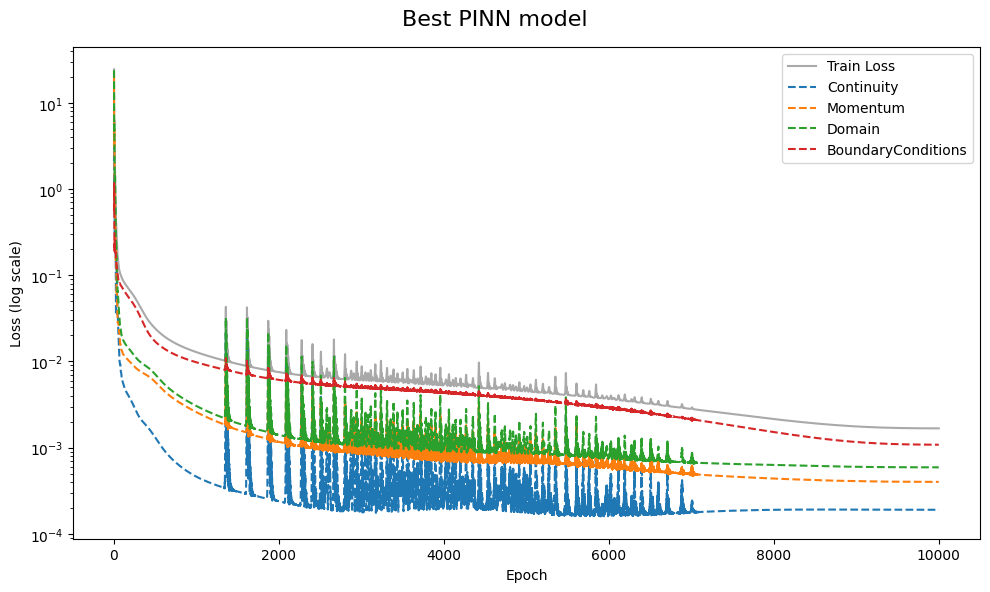

In [88]:
filename = 'best_pinn_model.pth'

if os.path.exists(filename):
    state_dict = torch.load('./' + filename, map_location=device)
    best_model.load_state_dict(state_dict)

else:
  cfg.epochs = 10000
  
  optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

  train_losses, val_losses, val_metrics = fit(best_model, 
                                            optimizer, 
                                            scheduler, 
                                            tags, 
                                            train_datasets=datasets_random, 
                                            valid_datasets=None, 
                                            info=True)

  plot_history(train_losses, val_losses, val_metrics, title = 'Best PINN model')

  # # Save the trained model
  # torch.save(best_model.state_dict(), filename)

  if IN_COLAB:  # Download the file
      from google.colab import files
      files.download(filename)

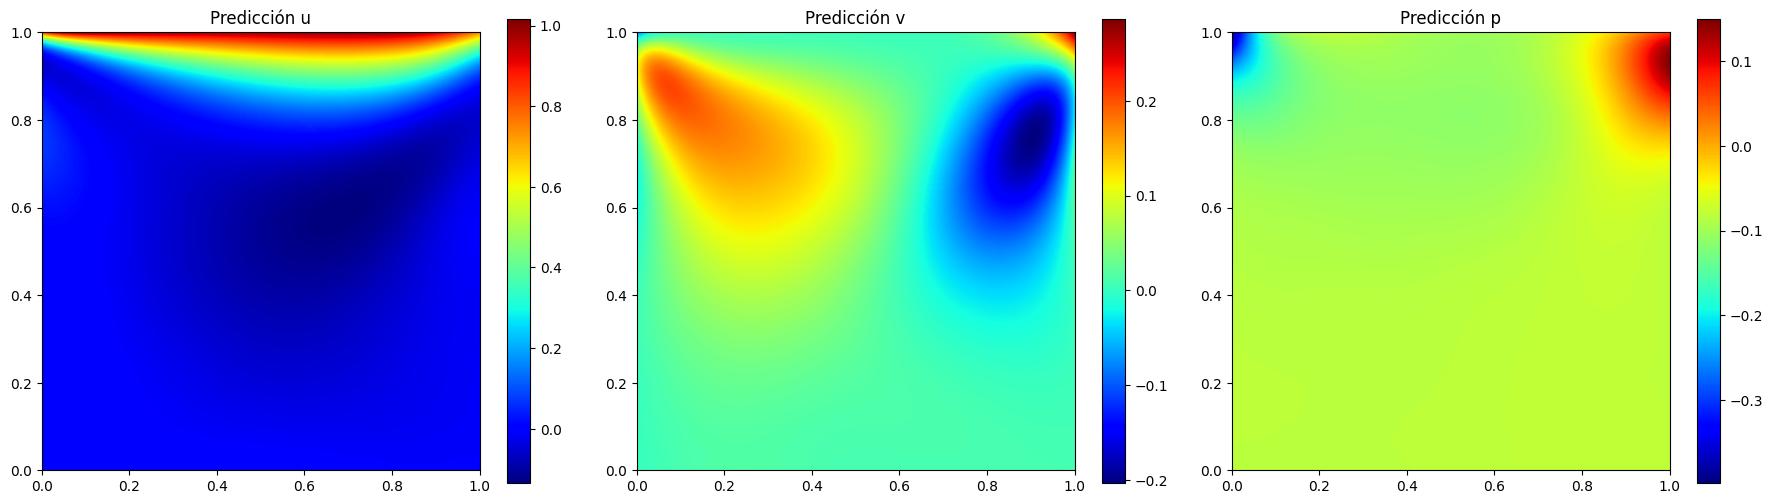

In [89]:
# Visualización de resultados (opcional)
def plot_predictions(model, resolution=1000):
    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')
    XY = torch.stack((X.flatten(), Y.flatten()), dim=1).to(device)
    with torch.no_grad():
        pred = model(XY).cpu().numpy()

    u = pred[:, 0].reshape(resolution, resolution).T
    v = pred[:, 1].reshape(resolution, resolution).T
    p = pred[:, 2].reshape(resolution, resolution).T

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    im0 = axs[0].imshow(u, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[0].set_title('Predicción u'); fig.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(v, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[1].set_title('Predicción v'); fig.colorbar(im1, ax=axs[1])
    im2 = axs[2].imshow(p, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[2].set_title('Predicción p'); fig.colorbar(im2, ax=axs[2])
    plt.tight_layout()
    plt.show()

plot_predictions(best_model)

ReLUperformsreallybad

ValueError: The rows of 'x' must be equal

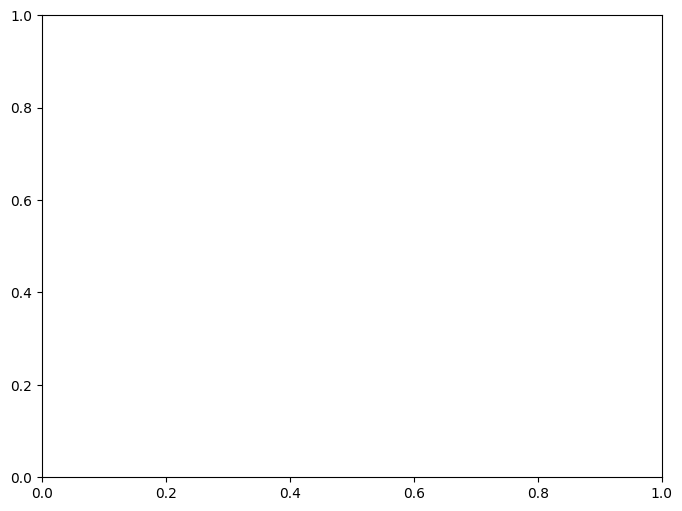

In [104]:
# Visualización de resultado:streamlines
def plot_streamlines(model, resolution=1000):
    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing='ij')
    XY = torch.stack((X_grid.flatten(), Y_grid.flatten()), dim=1).to(device)
    with torch.no_grad():
        pred = model(XY).cpu().numpy()

    u_pred = pred[:, 0].reshape(resolution, resolution)
    v_pred = pred[:, 1].reshape(resolution, resolution)

    # Plot streamlines   
    plt.figure(figsize=(8, 6))
    plt.streamplot(
        X_grid.numpy(), Y_grid.numpy(),
        u_pred, v_pred, density=2, linewidth=1, arrowsize=1
    )
    plt.title('Predicted Velocity Field (Streamlines)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()
    
plot_streamlines(best_model)

ValueError: The rows of 'x' must be equal

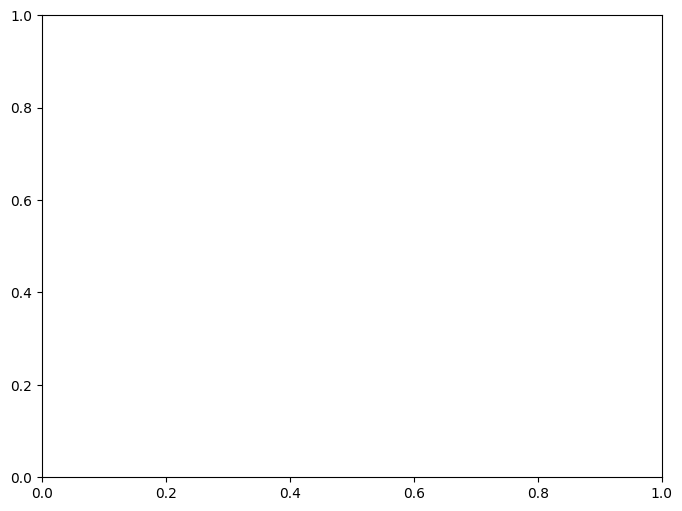

In [ ]:

def plot_streamlines(model, resolution=1000):
    # Crear vectores de puntos en torch
    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    
    # Crear mallas en torch
    X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')
    
    # Convertir a numpy y preparar para predicción
    XY = torch.stack((X.flatten(), Y.flatten()), dim=1).to(device)
    with torch.no_grad():
        pred = model(XY).cpu().numpy()
    
    # Reshape predicciones para u, v y p
    u = pred[:, 0].reshape(resolution, resolution)
    v = pred[:, 1].reshape(resolution, resolution)
    p = pred[:, 2].reshape(resolution, resolution)  # si quieres usar p también
    
    # Crear las mallas numpy
    X_np = X.numpy()
    Y_np = Y.numpy()

    # Dibuja las líneas de corriente
    plt.figure(figsize=(8,6))
    plt.streamplot(X_np, Y_np, u, v, density=2, linewidth=1, arrowsize=1)
    plt.title('Líneas de corriente predichas')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.show()

# Llamada a la función
plot_streamlines(best_model)